# 0. Attention
1. use the dataset after section 1.6 for preiction, the dataset name is train4
2. train5 dataset is another feature selection based on chi2 method, use train5 if train4 doesn't have a good performance
3. section 1.7 is feature selection after implementing xgboost model, it's a post-choosing method, try using it after our implementation.


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

/Users/Kelly/anaconda/lib/python3.4/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
import utility as u

train_file = "data_train.txt"
test_file = "shuffle_data_test.txt"
data_folder = 'data'
columns = ['click', 'weekday', 'hour', 'timestamp', 'log_type', 'user_id', 'user_agent', 'ip', 'region', 'city',
           'ad_exchange', 'domain', 'url', 'anon_url_id', 'ad_slot_id', 'width', 'height', 'visibility', 'format',
           'price', 'creative_id', 'key_page_url', 'advertiser_id', 'user_tags']

train, test = u.import_tr_te(train_file, test_file, columns, data_folder)

In [3]:
train.head()

,click,weekday,hour,timestamp,log_type,user_id,user_agent,ip,region,city,...,ad_slot_id,width,height,visibility,format,price,creative_id,key_page_url,advertiser_id,user_tags
0,0,6,0,20130606000104308,1,VhT3La5uDlaywOj,windows_chrome,122.233.40.*,94,95,...,mm_10058411_2865562_9929053,300,250,2,1,0,44966cc8da1ed40c95d59e863c8c75f0,361e128affece850342293213691a043,3386,"10057,10063,10024,13800,13866,10110"
1,0,6,0,20130606000104371,1,Vhk0Z35ULqFcBZc,windows_ie,180.107.223.*,80,85,...,4017603800,336,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,361e128affece850342293213691a043,3386,"10063,10059,13776,10111"
2,0,6,0,20130606000104420,1,Vhk7ZAnxPcKOjCb,windows_ie,111.120.123.*,298,299,...,2141208056,250,250,2,0,5,7097e4210dea4d69f07f0f5e4343529c,361e128affece850342293213691a043,3386,"10063,10111"
3,0,6,0,20130606000104436,1,VhkY1nFEPlkyeIC,windows_ie,112.95.93.*,216,219,...,415540879,250,250,2,0,5,7097e4210dea4d69f07f0f5e4343529c,361e128affece850342293213691a043,3386,10048
4,0,6,0,20130606000104450,1,VhLrOxuUPqd63CL,windows_chrome,113.200.249.*,333,334,...,2811067692,250,250,2,0,5,7097e4210dea4d69f07f0f5e4343529c,361e128affece850342293213691a043,3386,"10006,10057,14273"


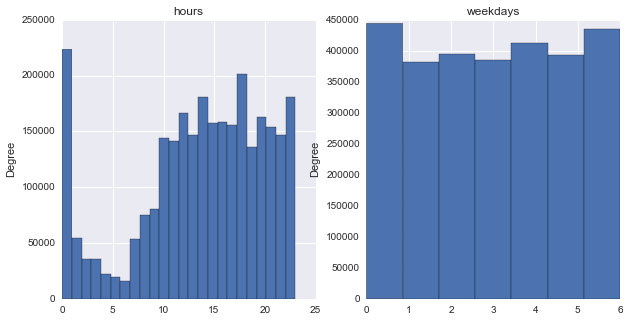

In [11]:
plt.subplot(121)            
train['hour'].plot(kind='hist',bins=24,figsize=(10,5))
plt.title('hours')
plt.subplot(122)             
train['weekday'].plot(kind='hist',bins=7)
plt.title('weekdays')


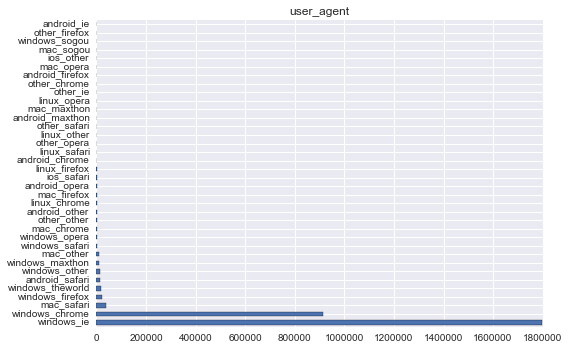

In [31]:
train.user_agent.value_counts().plot(kind='barh')
#plt.axis('equal')
plt.title('user_agent')

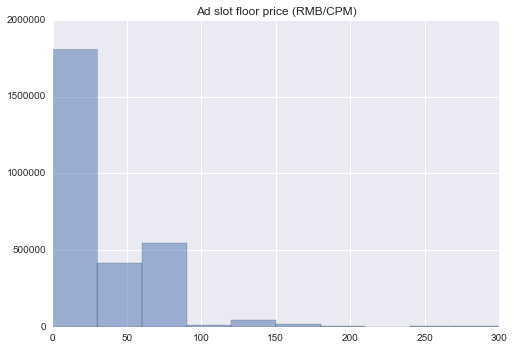

In [56]:
train['price'].hist(alpha=0.5)
plt.title('Ad slot floor price (RMB/CPM)')


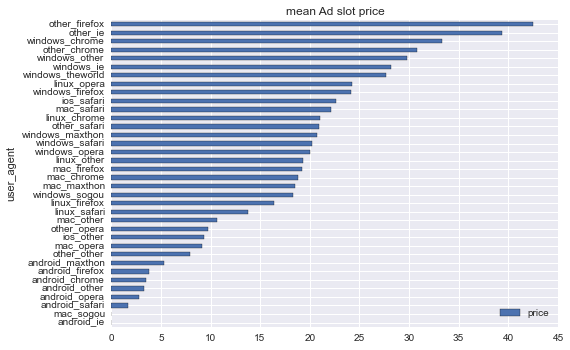

In [50]:
idx = [6,19]
df = train.iloc[:,idx]
x = df.groupby(['user_agent']).mean()
x.sort(columns='price').plot(kind='barh')
plt.title('mean Ad slot price')

## 1. Feature Engineering

### 1.1. Delete obvious meanningless factors
* user_id obviously meanningless
* ip is closely tied to user_id, still meanningless
* each customer has a unique timestamp, so the variation of this feature would be extremely large, which still meanningless for our prediction

In [4]:
train1 = train.drop(['user_id','ip','timestamp'],axis =1)
test1 = test.drop(['user_id','ip','timestamp'],axis =1)

### 1.2. Delete high-variation factors
since high-variation factors can not help to cluster our data set so as to make predictions, so it's better to delete highly varied factors
'url' varies a lot ,so we choose to delete them 

In [5]:
train2 = train1.drop('url',axis =1)
test2 = test1.drop('url',axis =1)

### 1.3. Delete zero-variation factors
Based on the principal component analysis (PCA), it is important that features have maximum variance for maximum uniqueness, so that each feature is as distant as possible (as orthogonal as possible) from the other features.
obviously, the 'log_type', 'advertiser_id' and 'anon_url_id' have zero standard deviations, which means these two factors don't have impact on our predictive process.

In [6]:
# Delete zero-variation factors
train.describe()

,click,weekday,hour,timestamp,log_type,region,city,ad_exchange,width,height,visibility,format,price,advertiser_id
count,2847802.000000,2847802.000000,2847802.000000,2.847802e+06,2847802,2847802.000000,2847802.000000,2847802.000000,2847802.000000,2847802.000000,2847802.000000,2847802.000000,2847802.000000,2847802
mean,0.000729,3.005293,13.788004,2.013061e+16,1,145.166020,150.065017,2.198610,580.746215,183.571554,2.243363,0.277444,29.441337,3386
std,0.026990,2.037767,6.625501,2.021288e+09,0,103.819625,105.043981,0.793964,320.683441,120.106046,19.892124,0.640043,36.785039,0
min,0.000000,0.000000,0.000000,2.013061e+16,1,0.000000,0.000000,1.000000,120.000000,60.000000,0.000000,0.000000,0.000000,3386
25%,0.000000,1.000000,10.000000,2.013061e+16,1,65.000000,75.000000,2.000000,300.000000,90.000000,0.000000,0.000000,4.000000,3386
50%,0.000000,3.000000,15.000000,2.013061e+16,1,146.000000,146.000000,2.000000,468.000000,90.000000,0.000000,0.000000,10.000000,3386
75%,0.000000,5.000000,19.000000,2.013061e+16,1,216.000000,221.000000,3.000000,1000.000000,250.000000,2.000000,0.000000,50.000000,3386
max,1.000000,6.000000,23.000000,2.013061e+16,1,395.000000,399.000000,3.000000,1000.000000,600.000000,255.000000,5.000000,300.000000,3386


In [7]:
train3 = train2.drop(['log_type','advertiser_id','anon_url_id','user_tags'],axis =1)
test3 = test2.drop(['log_type','advertiser_id','anon_url_id','user_tags'],axis =1)

In [8]:
train3.head()

,click,weekday,hour,user_agent,region,city,ad_exchange,domain,ad_slot_id,width,height,visibility,format,price,creative_id,key_page_url
0,0,6,0,windows_chrome,94,95,1,trqRTummPvas1m58uG,mm_10058411_2865562_9929053,300,250,2,1,0,44966cc8da1ed40c95d59e863c8c75f0,361e128affece850342293213691a043
1,0,6,0,windows_ie,80,85,2,5On-q5uvgN171m58uG,4017603800,336,280,2,0,5,ff5123fb9333ca095034c62fdaaf51aa,361e128affece850342293213691a043
2,0,6,0,windows_ie,298,299,2,trqRTu1yMI5o1m58uG,2141208056,250,250,2,0,5,7097e4210dea4d69f07f0f5e4343529c,361e128affece850342293213691a043
3,0,6,0,windows_ie,216,219,2,5KFEGK9RBTNEXMB4JKTI,415540879,250,250,2,0,5,7097e4210dea4d69f07f0f5e4343529c,361e128affece850342293213691a043
4,0,6,0,windows_chrome,333,334,2,trqRTu1yMI5o1m58uG,2811067692,250,250,2,0,5,7097e4210dea4d69f07f0f5e4343529c,361e128affece850342293213691a043


In [9]:
train3.dtypes

click            int64
weekday          int64
hour             int64
user_agent      object
region           int64
city             int64
ad_exchange      int64
domain          object
ad_slot_id      object
width            int64
height           int64
visibility       int64
format           int64
price            int64
creative_id     object
key_page_url    object
dtype: object

### 1.4. Change categorical data into numerical representatives using label encoder

In [10]:
def labelencoder(train_data):
    for f in train_data.columns:
        if train_data[f].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(np.unique(list(train_data[f].values)))
            train_data[f] = lbl.transform(list(train_data[f].values))
    return train_data

In [12]:
train4 = labelencoder(train3)

test4 = labelencoder(test3)
train4.head()

,click,weekday,hour,user_agent,region,city,ad_exchange,domain,ad_slot_id,width,height,visibility,format,price,creative_id,key_page_url
0,0,6,0,27,94,95,1,12217,50902,300,250,2,1,0,2,0
1,0,6,0,29,80,85,2,2394,39778,336,280,2,0,5,10,0
2,0,6,0,29,298,299,2,10271,14544,250,250,2,0,5,5,0
3,0,6,0,29,216,219,2,2218,41560,250,250,2,0,5,5,0
4,0,6,0,27,333,334,2,10271,23633,250,250,2,0,5,5,0


In [15]:
train4['format'].value_counts()

0    2176840
1     641176
5      29786
dtype: int64

### 1.5. Check correlations of different features

In [18]:
train4.corr()

,click,weekday,hour,user_agent,region,city,ad_exchange,domain,ad_slot_id,width,height,visibility,format,price,creative_id,key_page_url
click,1.000000,0.001207,0.001222,-0.028117,-0.000393,-0.000463,-0.009116,0.007037,0.004320,-0.004252,0.003949,0.001475,0.029800,-0.001309,-0.006310,-0.005025
weekday,0.001207,1.000000,-0.007751,0.000115,0.005180,0.005285,-0.017115,0.013214,-0.009441,0.047306,-0.023120,0.001876,0.009420,0.009385,0.048914,-0.019498
hour,0.001222,-0.007751,1.000000,0.023327,-0.029533,-0.027964,0.018494,0.003991,-0.041326,0.023709,-0.006040,-0.009972,-0.032521,0.052011,-0.003474,-0.007843
user_agent,-0.028117,0.000115,0.023327,1.000000,0.017649,0.019839,0.092076,-0.062026,-0.062500,0.030323,-0.037679,-0.035876,-0.126809,0.030703,0.077129,0.038941
region,-0.000393,0.005180,-0.029533,0.017649,1.000000,0.994930,-0.041845,0.044890,-0.046384,-0.050062,0.034780,-0.000483,0.004730,-0.028268,-0.027688,-0.064129
city,-0.000463,0.005285,-0.027964,0.019839,0.994930,1.000000,-0.042174,0.044563,-0.045607,-0.049506,0.035372,-0.000663,0.005571,-0.026233,-0.027828,-0.063664
ad_exchange,-0.009116,-0.017115,0.018494,0.092076,-0.041845,-0.042174,1.000000,-0.586959,0.134946,0.683185,-0.494768,-0.144063,-0.654401,0.547319,0.295534,0.884243
domain,0.007037,0.013214,0.003991,-0.062026,0.044890,0.044563,-0.586959,1.000000,-0.376577,-0.454707,0.306779,0.079578,0.249116,-0.295349,-0.200565,-0.684136
ad_slot_id,0.004320,-0.009441,-0.041326,-0.062500,-0.046384,-0.045607,0.134946,-0.376577,1.000000,0.267666,-0.105512,0.031566,0.259229,0.052586,-0.039279,0.500081
width,-0.004252,0.047306,0.023709,0.030323,-0.050062,-0.049506,0.683185,-0.454707,0.267666,1.000000,-0.778838,-0.085537,-0.352802,0.453295,0.522891,0.712679


## 2. Random Forest Model

### 2.1. Train_Test split

In [16]:
X_data = train4.drop('click',axis =1)
y_data = train4['click']
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_data, y_data, test_size=0.2, random_state=0)
X = test4

### 2.2 Build the model 

In [99]:
#logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train,y_train)



0.99927312343162988

In [102]:
pred0 = pd.DataFrame(lr.predict(X))
pred0.columns = ['click']


In [103]:
pred0['click'].value_counts()

0    2847802
dtype: int64

In [17]:
model= RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_train,y_train)

0.99964007319682158

### 2.3 Grid Search

### 2.4 Model Evaluation

In [19]:
model.score(X_test,y_test)

0.99916075714453767

In [20]:
model.feature_importances_

array([  1.17132666e-01,   2.08192472e-01,   5.75086667e-02,
         9.70866008e-02,   2.91684918e-01,   2.34112392e-04,
         9.62097476e-02,   1.03727749e-01,   3.50415446e-03,
         2.13047754e-03,   9.00272881e-03,   3.82148399e-03,
         5.96729545e-03,   3.00828394e-03,   7.88643514e-04])

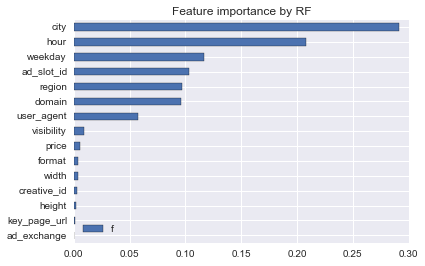

In [90]:
f = pd.DataFrame(model.feature_importances_)
f.index =  [ 'weekday', 'hour',  'user_agent',  'region', 'city',
           'ad_exchange', 'domain', 'ad_slot_id', 'width', 'height', 'visibility', 'format',
           'price', 'creative_id', 'key_page_url']
f.columns = ['f']
f.sort(columns='f').plot(kind='barh',title='Feature importance by RF')



### 2.5 Model Prediction

In [26]:
pred = pd.DataFrame(model.predict(X))
pred

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


In [29]:
pred.columns = ['click']

In [33]:
pred['click'].value_counts()

0    545420
1         1
dtype: int64

In [32]:
pred.groupby('click').count()

""
click
0
1


### 2.6 XGBOOST

In [34]:
param={
    'objective': 'binary:logistic',
    'base_score': 0.5,
    'colsample_bylevel': 1,
    'colsample_bytree': 0.5,
    'gamma': 0,
    'learning_rate': 0.1,
    'max_delta_step': 0,
    'max_depth':10,
    'min_child_weight': 31,
    'missing': None,
    'n_estimators': 100,
    'nthread': 8,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 12,
    'seed': 1,
    'silent': 0,
    'subsample': 1 
}

In [36]:
xgb_model = xgb.XGBClassifier(**param)

clf = xgb_model.fit(X_train,y_train)

clf.score(X_train,y_train)

0.99918050812008041

In [38]:
clf.score(X_test,y_test)

0.99908701614050122

In [39]:
clf.predict_proba(X)

array([[ 0.99496102,  0.00503897],
       [ 0.99420595,  0.00579407],
       [ 0.98574471,  0.01425531],
       ..., 
       [ 0.99544418,  0.00455581],
       [ 0.99595726,  0.00404276],
       [ 0.99731213,  0.00268787]], dtype=float32)

In [40]:
pred1 = pd.DataFrame(clf.predict_proba(X))

In [42]:
pred1.columns = ['click','not_click']
pred1

,click,not_click
0,0.994961,0.005039
1,0.994206,0.005794
2,0.985745,0.014255
3,0.997707,0.002293
4,0.997309,0.002691
5,0.994240,0.005760
6,0.997713,0.002287
7,0.994884,0.005116
8,0.995994,0.004006
9,0.995104,0.004896


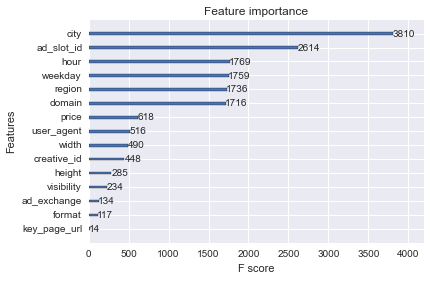

In [51]:
xgb.plot_importance(clf)


In [ ]:
pred1.to_csv('./pred1.csv')

### 1.6 Univariate feature selection
this method is another try if the former dataset can not give a good performance

Univariate feature selection works by selecting the best features based on univariate statistical tests. 

SelectKBest removes all but the k highest scoring features

In [119]:
# by changing the k value, we can decide how many topest factors we want to keep 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
X,y = train4.drop(['click'],axis =1),train4['click']
print(X.shape)
X_new = SelectKBest(chi2, k=3).fit(X, y) 
#print(X_new.shape)

(2847802, 15)


SelectKBest(k=3, score_func=<function chi2 at 0x10dd25b70>)

In [118]:
X_new

SelectKBest(k=3, score_func=<function chi2 at 0x10dd25b70>)

### 1.7 Feature selection after implementation
this method is based on the xgboost model's feature importance attribute, if the corresponding feature_importance_ value are below the threshold parametor, we can use this method to delete the unimportant features.

In [97]:
# Since our task is a prediction process, so we use a clf(short of classifier) as a discipline of choosing features.
from sklearn.feature_selection import SelectFromModel
X,y = train4.drop(['click'],axis =1),train4['click']
print(X.shape)
xgboost = xgboost
clf =xgboost.fit(X,y)
clf.feature_importance
model = SelectFromModel(clf, prefit=True)
X_new = model.transform(X)
print(X_new.shape)

(2847802, 15)


AttributeError: 'module' object has no attribute 'fit'

In [ ]:
X_tsne = TSNE(learning_rate=100).fit_transform(train4.drop(['click'],axis =1))

In [ ]:
scatter(X_tsne[:, 0], X_tsne[:, 1], c=train4['click'])